In [1]:
# Import libraries
from utils import get_taxi_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import geopandas

In [2]:
def import_taxi_zones(path,borough_name):
    # import taxi zones from NYC Taxi & Limousine Commision, and set index
    zones = geopandas.read_file(path)
    zones = zones.set_index("OBJECTID")
    zones.index.rename("grid",inplace=True)
    
    # change coordinate reference system to New York specific
    # source: https://epsg.io/?q=new+york
    zones.to_crs("EPSG:32118")
    
    # save zones within Manhattan
    borough = zones.loc[zones.borough.str.contains(borough_name)].index.to_numpy()
    
    return zones, borough

In [3]:
def import_taxi_data(date):
    # extract year and month from date
    year, month, _ = date.split('-')
    
    # define import arguments
    vehicle_type = 'yellow'
    desired_columns = ['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','trip_distance',
                   'fare_amount','PULocationID','DOLocationID']
    
    # import data from specified year and month
    df = get_taxi_data(year, month, vehicles=vehicle_type, columns=desired_columns, save=False)
    
    # drop any data where dropoff datetime outside the desired month
    df.drop(df.loc[df.tpep_pickup_datetime.dt.month != int(month)].index,inplace=True)
    
    # drop any data where pick-up or drop-off LocationID is 264 or 265, they are equivalent to NaN values
    df.drop(df.loc[(df.PULocationID==264)|(df.PULocationID==265)].index,inplace=True)
    
    # clean the data
    df = clean_data(df)
    
    return df

In [4]:
## Data cleaning
def clean_data(df):
    # passenger_count column is missing data, so fill Na values with -1 and set data type to int64
    df["passenger_count"].fillna(-1,inplace=True)
    df["passenger_count"] = df["passenger_count"].astype("int64")

    # drop any data with negative trip_distance or fare_amount
    df.drop(df.loc[df.trip_distance < 0].index,inplace=True)
    df.drop(df.loc[df.fare_amount < 0].index,inplace=True)

    # drop any data beyond 99th percentile or trip distance
    df.drop(df.loc[df.trip_distance > df.trip_distance.quantile(0.99)].index,inplace=True)
    df.drop(df.loc[df.fare_amount > df.fare_amount.quantile(0.99)].index,inplace=True)
    
    return df

In [5]:
def find_median_frequency(zones,df,column):
    # find all dates in the month for which there is data
    days_in_month = df.tpep_pickup_datetime.dt.day.unique()

    # initialise dataframe for drop-off location counts for each number of days 
    dropoff_freq = pd.DataFrame(np.zeros((len(zones.index.unique()),len(days_in_month))),index=zones.index,columns=days_in_month,dtype=int)
    
    # count the number of drop-offs or pick-ups in each grid for each day
    for i in range(len(days_in_month)):
        # count values of each drop-off location for each day
        dropoff_freq.loc[:,i] = df.loc[df.tpep_pickup_datetime.dt.day == days_in_month[i],column].value_counts()
    
    # calculate median of drop-off or pick-up frequency for each location
    median_loc = dropoff_freq.median(axis=1)
    
    return median_loc

In [21]:
def frequency_percent_diff(date,df,column):
    '''
    percentage difference from median is equal to measured minus median divided by the absolute value of the
    median, times 100
    
    '''
    # calculate pickup-off frequency for each location on specified date
    counts = df.loc[df.tpep_pickup_datetime.dt.day == int(date.split("-")[-1]),column].value_counts()
    
    # define new data frame for frequency for each zone, filling NaN as function cannot count 0
    frequency = pd.DataFrame(index=zones.index)
    frequency.insert(0,"freq",counts)
    frequency.fillna(0,inplace=True)
    
    # calculate median of pick-up frequency for each location
    median = find_median_frequency(zones,df,column)
    
    # calculate measured minus median
#     numerator = frequency.sub(median,axis=0)
    
    # calculate absolute value of median, filling NaN values with 1 to avoid division by 0
    denominator = median.fillna(1).abs()
    
    # calculate difference
    diff = frequency.div(denominator,axis=0)
    
    # calulate percentage difference
    percent_diff = diff.fillna(0) * 100
    
    return percent_diff

In [7]:
## Plot dropoff heatmap
def plot_dropoff_heatmap(date,df,zones,borough):
    # find drop-off percentage increase over median for particular day
    zones["dropoff_diff"] = frequency_percent_diff(date,df,"DOLocationID")
    
    # instantiate plot
    fig,ax = plt.subplots(figsize=(10,6))
    
    # plot heatmap
    zones.loc[borough,["geometry","dropoff_diff"]].dropna().plot("dropoff_diff",legend=True,ax=ax,vmin=-1)
    
    # plot styling
    ax.set_title("Daily Percentage Difference in Drop-Off Frequency Relative to Median Value")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display plot
    plt.show()

In [8]:
## Plot pickup heatmap
def plot_pickup_heatmap(date,dropoff_location,df,zones,borough):
    # select data
    subset_df = df.loc[df.DOLocationID == dropoff_location]
    
    # find pickup percentage diff over median for particular day
    zones["pickup_diff"] = frequency_percent_diff(date,subset_df,"PULocationID")
    
    # instantiate plot
    fig,ax = plt.subplots(figsize=(10,6))
    
    # plot heatmap
    zones.loc[borough,["geometry","pickup_diff"]].dropna().plot("pickup_diff",legend=True,ax=ax)
    
    # plot styling
    ax.set_title("Daily Percentage Difference in Pick-Up Frequency Relative to Median Value")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display plot
    plt.show()

In [9]:
## Plot fare heatmap
def plot_fare_heatmap(date,dropoff_location,df,zones,borough):
    # select data
    subset_df = df.loc[df.DOLocationID == dropoff_location]
    
    # calculate median fare for each pickup location
    fares = pd.DataFrame(index=zones.index)
    fares.insert(0,"fares",subset_df.groupby("PULocationID").fare_amount.median())
    fares.fillna(0,inplace=True)
    print(fares)
    
    # find pickup percentage difference over median for particular day
    percent_diff = frequency_percent_diff(date,subset_df,"PULocationID")
    
    # change percentage_increase to decimal
    decimal_diff = percent_diff/100
    
    # calculate fare multiplied by pickup decimal increase to find demand surges
    zones["fare_surge"] = fares.iloc[:,0] * decimal_diff.iloc[:,0]
    
    # instantiate plot
    fig,ax = plt.subplots(figsize=(10,6))
    
    # plot heatmap
    zones.loc[borough,["geometry","fare_surge"]].dropna().plot("fare_surge",legend=True,ax=ax)
    
    # plot styling
    ax.set_title("Total Fare Potential of Demand Surge for Given Pick-Up Location")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display plot
    plt.show()

In [18]:
## Import the relevant data

# import taxi zones data
path = "data/taxi_zones/taxi_zones.shp"
zones, manhattan = import_taxi_zones(path, "Manhattan")

# select a date to investigate
date = "2018-07-01"

# import the relevant data
df = import_taxi_data(date)

File not in current folder; trying to download data...


In [11]:
## Explore the map of New York taxi zones
zones.loc[manhattan].explore()

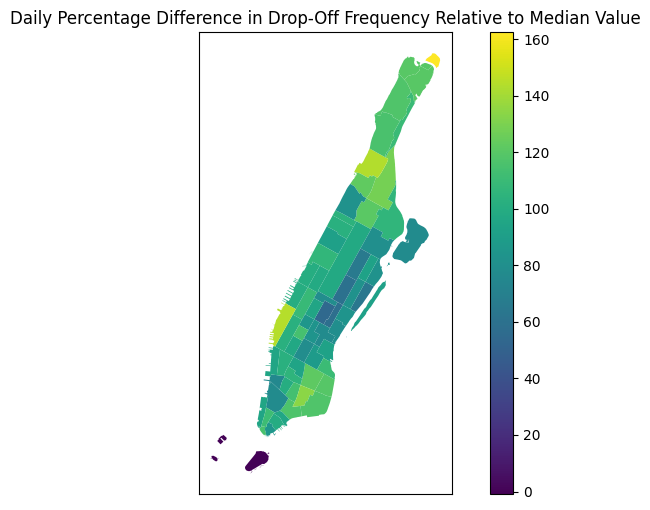

In [22]:
## Explore the drop-off frequency relative to the median drop-off frequency for the month

# plot the heatmap
plot_dropoff_heatmap(date,df,zones,manhattan)

In [23]:
# explore the heatmap
zones.loc[manhattan,["geometry","zone","borough","dropoff_diff"]].dropna().explore("dropoff_diff",legend=True)

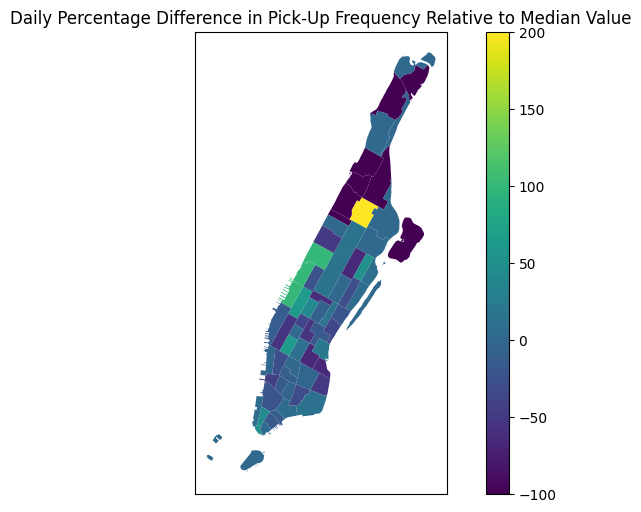

In [14]:
## Explore pick-up locations for a particular drop-off grid relative to the median pick-up locations

# chose a drop-off grid to investigate
desired_dropoff_grid = 45

# plot the heatmap
plot_pickup_heatmap(date,desired_dropoff_grid,df,zones,manhattan)

In [15]:
# explore the heatmap
zones.loc[manhattan,["geometry","zone","borough","pickup_diff"]].dropna().explore("pickup_diff",legend=True)

      fares
grid       
1       0.0
2       0.0
3       0.0
4       9.5
5       0.0
...     ...
259     0.0
260    46.5
261     8.5
262    21.0
263    22.5

[263 rows x 1 columns]


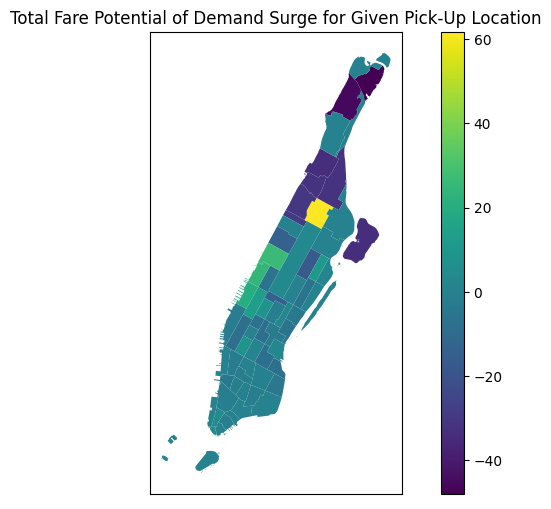

In [16]:
## Explore the fare potential pick-up locations

# The fare potential is the percentage difference in pick-up demand from normal times the median fare for the journey
# to the selected drop-off grid

# plot the heatmap
plot_fare_heatmap(date,desired_dropoff_grid,df,zones,manhattan)

In [17]:
# explore the heatmap
zones.loc[manhattan,["geometry","zone","borough","fare_surge"]].dropna().explore("fare_surge",legend=True)